# Importing Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt

from keras import backend as K

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, RepeatVector, TimeDistributed, Bidirectional
from keras.layers.recurrent import LSTM
from keras.models import load_model

import keras
import h5py
import requests
import os

from sklearn.externals import joblib

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, explained_variance_score
import seaborn as sns
import matplotlib.pyplot as plt

import joblib



Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Reproducibility

In [ ]:
np.random.seed(8)

# Back-Step & Predition-Step Size Function

In [ ]:
 #this is for looking back and looking into future for data set
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    print (type(X),type(y))
    return X, y



# Making Forcast Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/weather/weather-denmark.csv')


dataset = dataset[dataset.City == 'Aalborg']

dataset = dataset[['WindSpeed','WindDir','Temp']]

dataset.dropna(inplace=True)

dataset.head()



,WindSpeed,WindDir,Temp
0,11.3,290.0,5.0
1,9.2,270.0,4.0
2,9.2,280.0,4.0
3,9.2,280.0,4.0
4,8.7,270.0,4.0


# Normilzing Data

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

def normalize_data(df):
    df['WindSpeed'] = min_max_scaler.fit_transform(df.WindSpeed.values.reshape(-1,1))
    df['WindDir'] = min_max_scaler.fit_transform(df.WindDir.values.reshape(-1,1))
    df['Temp'] = min_max_scaler.fit_transform(df.Temp.values.reshape(-1,1))

    return df
df = normalize_data(dataset)
df.head()

,WindSpeed,WindDir,Temp
0,0.343465,0.800000,0.518519
1,0.279635,0.742857,0.500000
2,0.279635,0.771429,0.500000
3,0.279635,0.771429,0.500000
4,0.264438,0.742857,0.500000


# Converting pd.DF to np.Array

In [ ]:
new_data = np.array(dataset)
print(new_data.shape)

(731617, 3)


# Looking back 15 steps, Looking ahead 6 steps
### Change the step sizes for experimentation accordingly but keep in mind that this affects how the model is built

In [ ]:
past_steps = 15
future_steps = 6

X, y = split_sequences(new_data, past_steps, future_steps)
X, y = np.array(X), np.array(y)
print(X.shape,y.shape)

<class 'list'> <class 'list'>
(731597, 15, 3) (731597, 6)


# Making Train and Test Datasets

In [ ]:
split_point=int(len(X)*0.9)

train_x = X[:split_point]

train_y = y[:split_point]

test_x = X[split_point:]

test_y = y[split_point:]


# Number of Multi-Variate features used

In [ ]:
n_features = X.shape[2]
print(n_features)

3


# Define and Compile Model

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(past_steps, n_features), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200, activation='relu')))
model.add(Dropout(0.2))
model.add(Dense(future_steps,activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

W0727 11:01:53.915930 139787400976256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 11:01:53.956190 139787400976256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# Train Model
if you want to load a pre-trained model skip this step

In [ ]:
model.fit(train_x, train_y, epochs=15, batch_size=512,  validation_data=[test_x, test_y],verbose=1, shuffle=True)

Train on 658433 samples, validate on 73160 samples
Epoch 1/15
658433/658433 [==============================] - 304s 462us/step - loss: 0.0036 - mean_absolute_error: 0.0377 - val_loss: 5.5941e-04 - val_mean_absolute_error: 0.0189
Epoch 2/15
658433/658433 [==============================] - 303s 459us/step - loss: 0.0011 - mean_absolute_error: 0.0246 - val_loss: 2.8501e-04 - val_mean_absolute_error: 0.0122
Epoch 3/15
658433/658433 [==============================] - 307s 466us/step - loss: 8.5474e-04 - mean_absolute_error: 0.0217 - val_loss: 4.1732e-04 - val_mean_absolute_error: 0.0158
Epoch 4/15
658433/658433 [==============================] - 303s 460us/step - loss: 7.1457e-04 - mean_absolute_error: 0.0195 - val_loss: 6.5201e-04 - val_mean_absolute_error: 0.0201
Epoch 5/15
658433/658433 [==============================] - 309s 469us/step - loss: 6.1697e-04 - mean_absolute_error: 0.0177 - val_loss: 4.9678e-04 - val_mean_absolute_error: 0.0171
Epoch 6/15
658433/658433 [=====================

# Save Model / Load Model
### Un-comment the load option if you want to load a previously trained model and comment out the save option
### Un-comment the save option if you want to save the current trained model and comment out the load option
## Take consideration of the name of the model when you save and load them.

In [ ]:
#model.save('/content/drive/My Drive/weather/ingolf.h5')

model = load_model('/content/drive/My Drive/weather/ingolf.h5')

model.summary()

W0727 11:02:16.376158 139787400976256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 11:02:16.387995 139787400976256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 11:02:16.932116 139787400976256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0727 11:02:16.943833 139787400976256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Ins

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 15, 400)           326400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 400)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 400)               961600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 2406      
Total params: 1,290,406
Trainable params: 1,290,406
Non-trainable params: 0
_________________________________________________________________


# Prediction on test data

In [ ]:
pred_y = model.predict(test_x, verbose=1)

73160/73160 [==============================] - 84s 1ms/step


# Variance Score on Normalized Data

In [ ]:
score = explained_variance_score(test_y, pred_y)
print(score)

0.980643089334842


# Denormalizing 

In [ ]:
denorm_ytest = min_max_scaler.inverse_transform(test_y)
denorm_ypred = min_max_scaler.inverse_transform(pred_y)

# Variance Score on Normalized Data
### The closer the variance score is to 1 the better the model is

In [ ]:
score1 = explained_variance_score(denorm_ytest, denorm_ypred)
print(score1)

0.9806430886739372


In [ ]:
print(denorm_ypred[0:5])

[[13.295528  13.219829  13.199593  13.200182  13.298666  13.484341 ]
 [13.186409  13.096976  13.059955  13.042304  13.123256  13.290545 ]
 [13.369486  13.3195715 13.318065  13.328848  13.43346   13.618873 ]
 [13.216275  13.192801  13.219793  13.257291  13.384411  13.587807 ]
 [12.275006  12.238281  12.252737  12.2834425 12.394569  12.577643 ]]


In [ ]:
print(denorm_ytest[0:5])

[[13.  13.2 13.  12.  11.8 12. ]
 [13.2 13.  12.  11.8 12.  12. ]
 [13.  12.  11.8 12.  12.  11.9]
 [12.  11.8 12.  12.  11.9 12. ]
 [11.8 12.  12.  11.9 12.  13. ]]


## The more overlapping the lines are the better the prediction, as we look more steps ahead the model accuracy drops

In [ ]:
%matplotlib inline

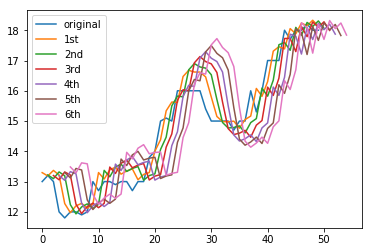

In [ ]:
plt.plot(range(0,50),denorm_ytest[0:50,0], label='original')
plt.plot(range(0,50),denorm_ypred[0:50,0], label='1st')
plt.plot(range(1,51),denorm_ypred[0:50,1], label='2nd')
plt.plot(range(2,52),denorm_ypred[0:50,2], label='3rd')
plt.plot(range(3,53),denorm_ypred[0:50,3], label='4th')
plt.plot(range(4,54),denorm_ypred[0:50,4], label='5th')
plt.plot(range(5,55),denorm_ypred[0:50,5], label='6th')
plt.legend()

###Change the instance value to plot the graph for that instance plus future steps into prediction (which in this case is 6 but it isn't hardcoded, for a new model with different step size into the future it will plot accordingly)



In [ ]:
instance = 50

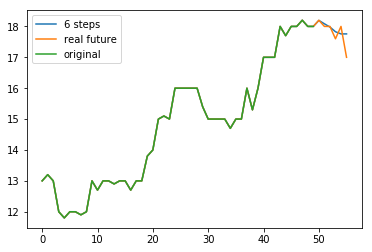

In [ ]:
future_predictions = np.concatenate((denorm_ytest[0:instance,0].reshape(instance,1),denorm_ypred[instance+1,:].reshape(future_steps,1)))
plt.plot(range(0,instance+6),future_predictions, label=str(future_steps)+' steps')
plt.plot(range(0,instance+6),denorm_ytest[0:instance+6,0], label='real future')
plt.plot(range(0,instance),denorm_ytest[0:instance,0], label='original')
plt.legend()

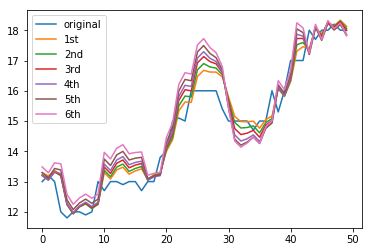

In [ ]:
plt.plot(range(0,50),denorm_ytest[0:50,0], label='original')
plt.plot(range(0,50),denorm_ypred[0:50,0], label='1st')
plt.plot(range(0,50),denorm_ypred[0:50,1], label='2nd')
plt.plot(range(0,50),denorm_ypred[0:50,2], label='3rd')
plt.plot(range(0,50),denorm_ypred[0:50,3], label='4th')
plt.plot(range(0,50),denorm_ypred[0:50,4], label='5th')
plt.plot(range(0,50),denorm_ypred[0:50,5], label='6th')
plt.legend()